In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## ABOUT THE DATASET
1. Here we are using the Fama-French model that was developed in 

In [99]:
brka_rets = pd.read_csv('brka_d_ret.csv',parse_dates=True, index_col=0)
# fff_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv')
fff_data = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')

In [100]:
def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())
    
# brka_m = brka_rets.resample('M').apply(compound).to_period('M')
brka_m = brka_rets.resample('D').apply(compound).to_period('D')

In [101]:
brka_m['DATE'] = brka_m.index
brka_m['DATE'] = brka_m['DATE'].apply(lambda x:pd.to_datetime(str(x),format='%Y-%m-%d')) 
brka_m.set_index('DATE',inplace=True)

In [102]:
# fff_data['DATE'] = fff_data['DATE'].apply(lambda x:pd.to_datetime(str(x),format='%Y%m')) 
fff_data['DATE'] = fff_data['DATE'].apply(lambda x:pd.to_datetime(str(x),format='%Y-%m-%d')) 

In [103]:
fff_data.set_index('DATE',inplace=True)
# fff_data = fff_data.to_period('M')
fff_data = fff_data/100

In [104]:
for col in fff_data.columns[1:5]:
    fff_data[col] = fff_data[col]-fff_data['RF']

In [105]:
# idx = np.intersect1d(fff_data.index, brka_m.index)
# idx

type(brka_m.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [106]:
df = pd.merge(left=brka_m,right=fff_data,left_index=True,how='left',right_index=True)

In [107]:
df['BRKA-RF'] = df['BRKA']-df['RF']
df.head()

,BRKA,Mkt-RF,SMB,HML,RMW,CMA,RF,BRKA-RF
DATE,,,,,,,,
1990-01-02,-0.005764,0.0144,-0.00696,-0.00096,0.00164,-0.00466,0.00026,-0.006024
1990-01-03,0.000000,-0.0006,0.00694,-0.00286,0.00114,-0.00456,0.00026,-0.000260
1990-01-04,0.005797,-0.0071,0.00414,-0.00246,-0.00086,-0.00056,0.00026,0.005537
1990-01-05,-0.005764,-0.0085,0.00714,-0.00236,-0.00036,-0.00146,0.00026,-0.006024
1990-01-06,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
df.dropna(inplace=True)

In [109]:
df.columns

Index(['BRKA', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'BRKA-RF'], dtype='object')

In [110]:
X_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
y_col = ['BRKA-RF']

In [111]:
df.isna().sum()

BRKA       0
Mkt-RF     0
SMB        0
HML        0
RMW        0
CMA        0
RF         0
BRKA-RF    0
dtype: int64

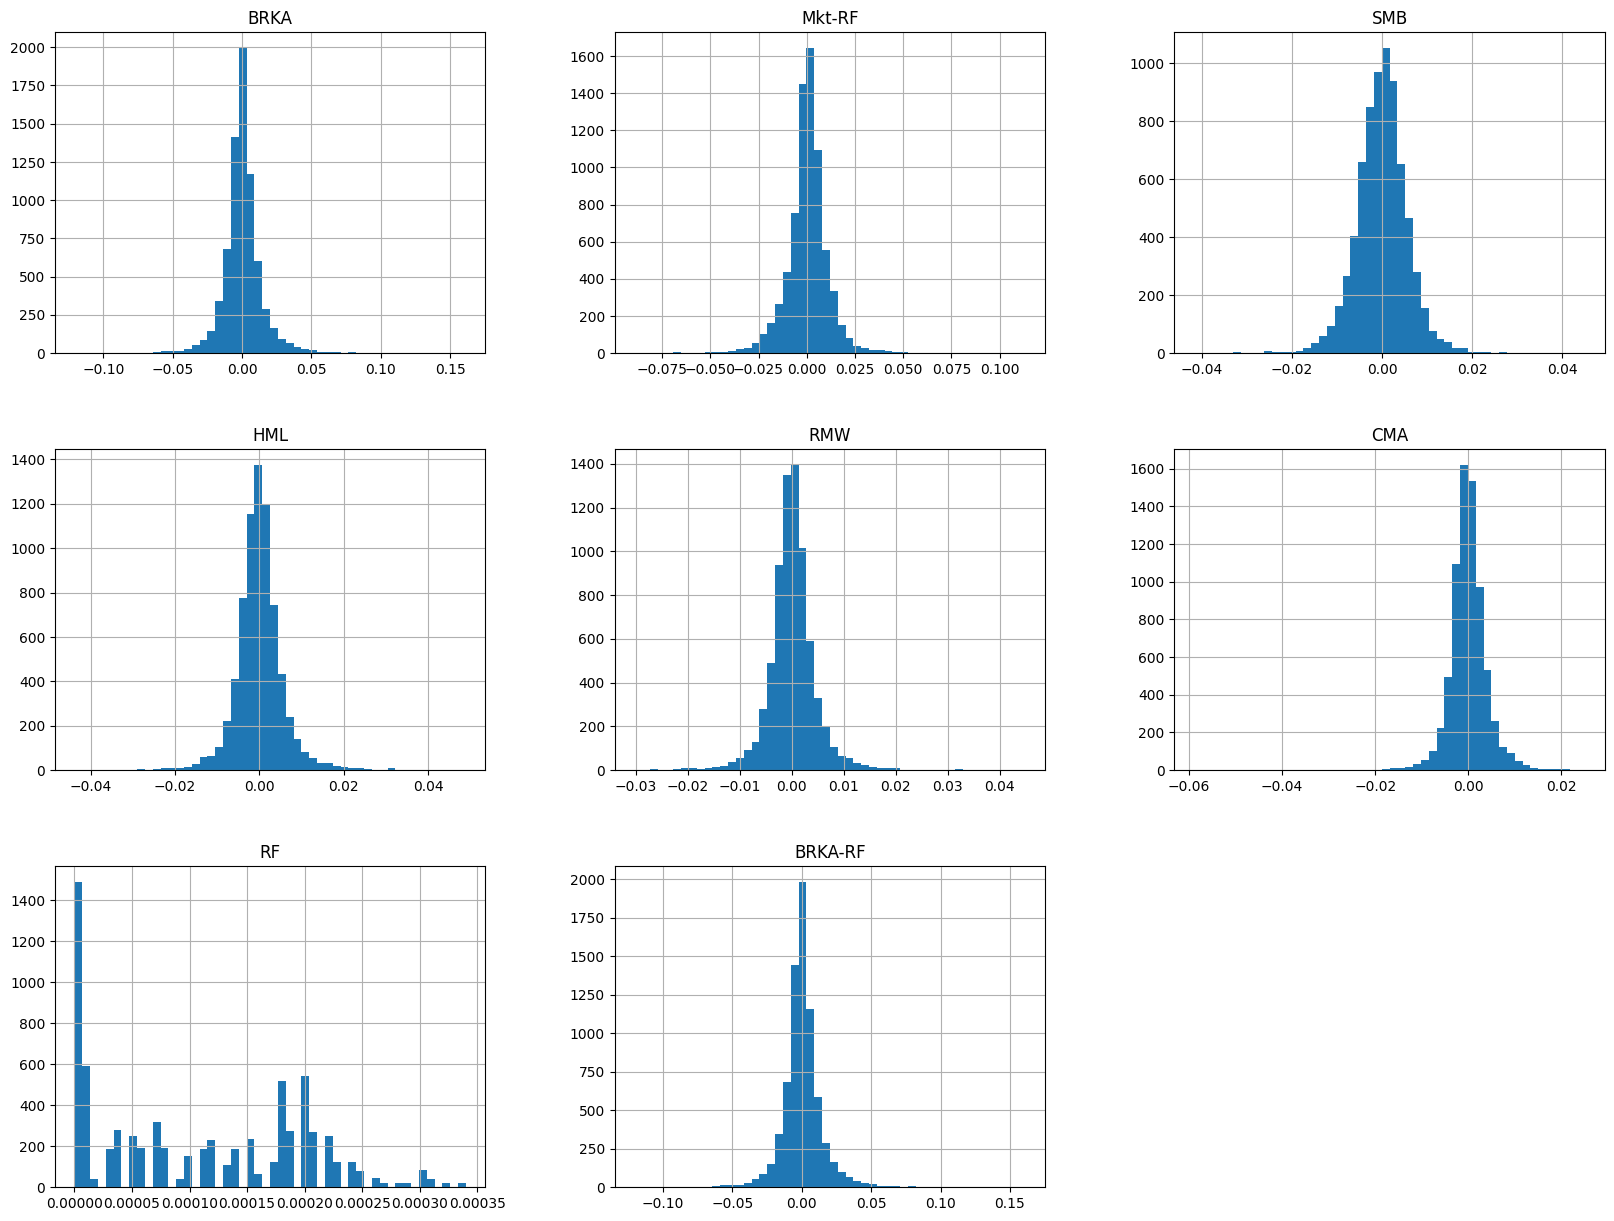

In [112]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [113]:
df[X_cols+y_col].corr(method="pearson").style.background_gradient(cmap='coolwarm').format(precision=4)


,Mkt-RF,SMB,HML,RMW,CMA,BRKA-RF
Mkt-RF,1.0000,-0.0021,-0.0573,-0.3621,-0.3432,0.4826
SMB,-0.0021,1.0000,0.0512,-0.2925,0.0447,-0.0146
HML,-0.0573,0.0512,1.0000,0.0406,0.5020,0.1246
RMW,-0.3621,-0.2925,0.0406,1.0000,0.2186,-0.2232
CMA,-0.3432,0.0447,0.5020,0.2186,1.0000,-0.1044
BRKA-RF,0.4826,-0.0146,0.1246,-0.2232,-0.1044,1.0000


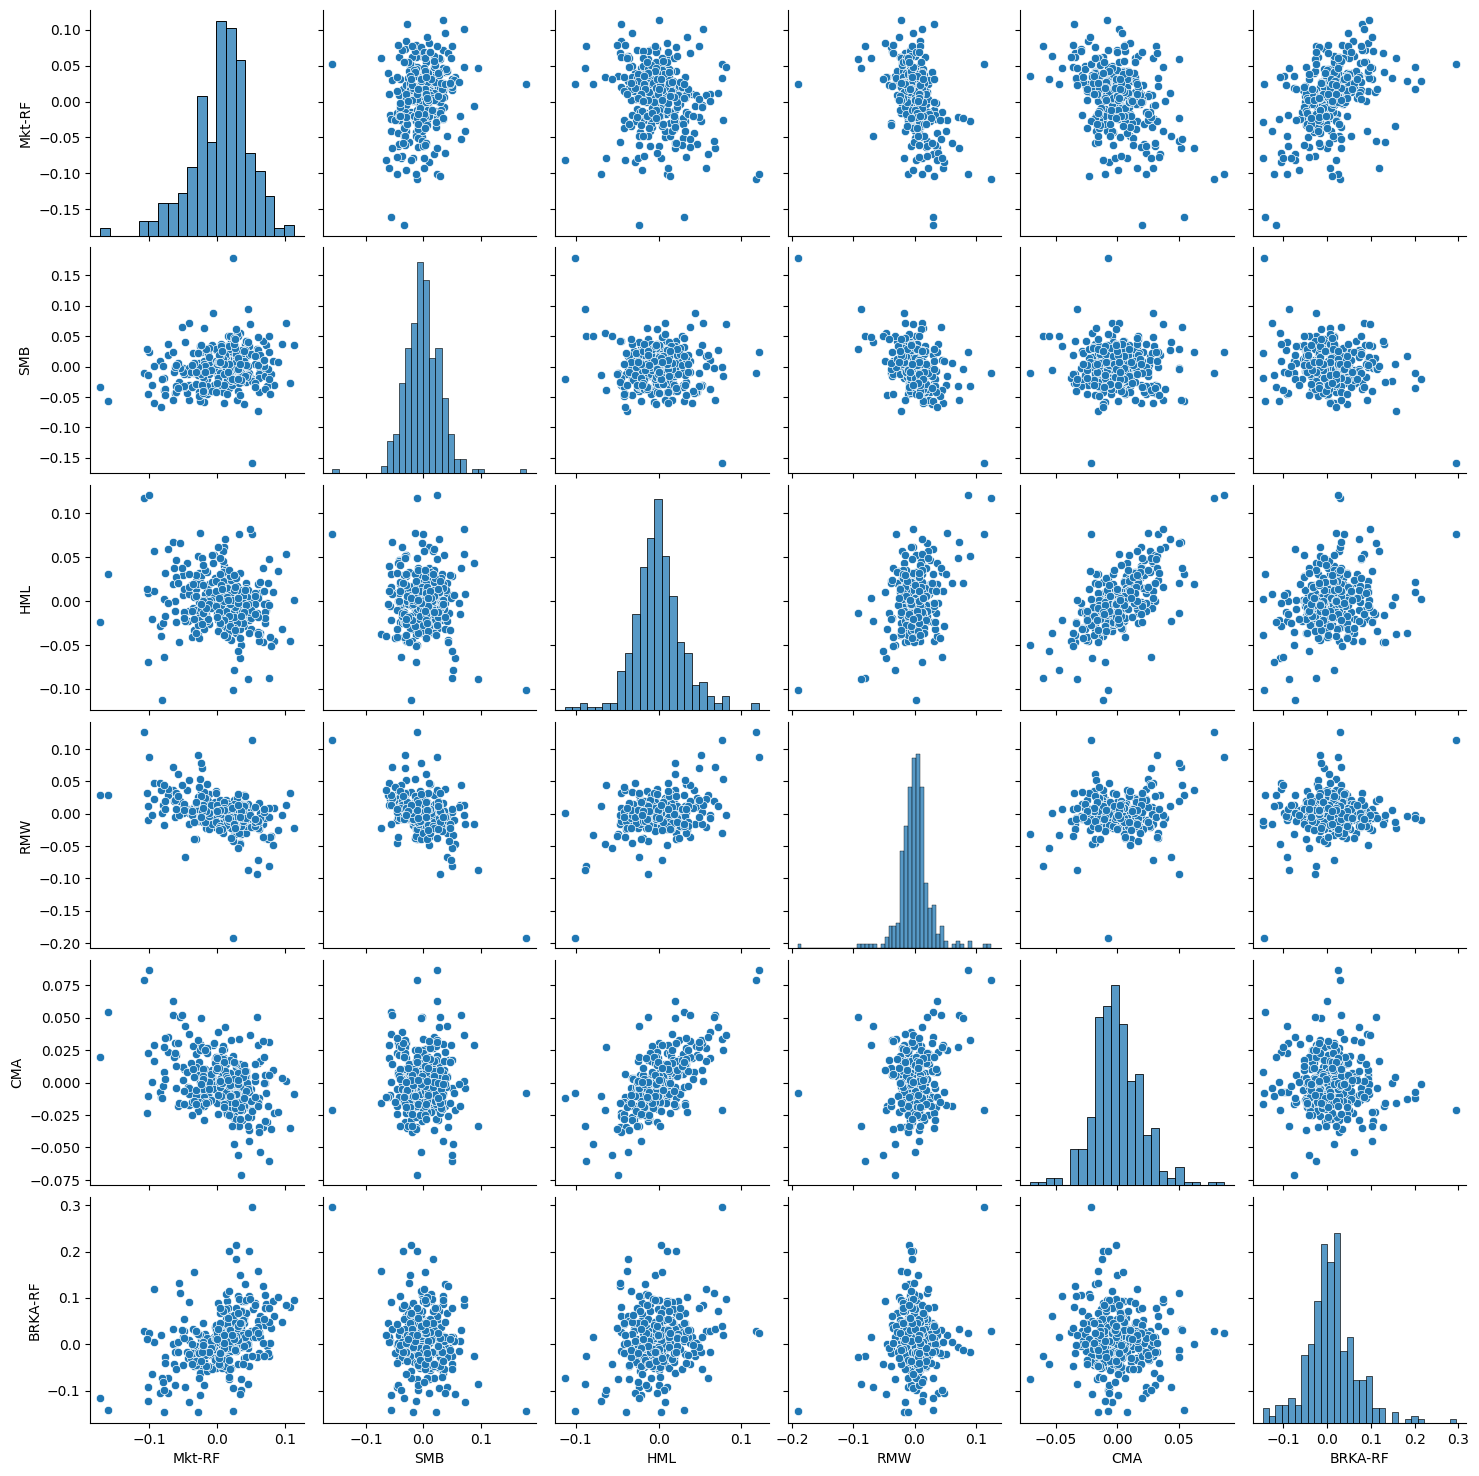

In [95]:
sns.pairplot(df[X_cols+y_col])
plt.show()

In [114]:
from sklearn.model_selection import train_test_split
X = df[X_cols]
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)


## LINEAR REGRESSION

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
lin_reg = LinearRegression()

cv_lin_reg = cross_validate(lin_reg,X_train,y_train,cv=4,scoring='neg_mean_squared_error',return_train_score=True)
print(cv_lin_reg)

lin_reg_ = [-cv_lin_reg['train_score'].mean(),-cv_lin_reg['test_score'].mean()]

print(f"The train loss {lin_reg_[0]}")
print(f"The validation loss {lin_reg_[1]}")

{'fit_time': array([0.07270241, 0.00799441, 0.00800157, 0.00802135]), 'score_time': array([0.00802827, 0.00800776, 0.        , 0.        ]), 'test_score': array([-0.00015477, -0.00029925, -0.00010753, -0.00018394]), 'train_score': array([-0.00018752, -0.00014185, -0.00020333, -0.00017761])}
The train loss 0.00017757657526451398
The validation loss 0.0001863738067511029


In [116]:
coeff_list = [lin_reg.fit(X_train,y_train).coef_.tolist()[0]]
linear_coeff_df = pd.DataFrame(coeff_list,columns=X_train.columns.tolist())
linear_coeff_df

,Mkt-RF,SMB,HML,RMW,CMA
0,0.554987,-0.095365,0.368667,-0.241933,-0.055945


## REGULARIZATION IN LINEAR REGRESSION

In [141]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn.model_selection import cross_validate

alpha_list = [0.001,0.01,0.1,1,10]

def regularization_run(X,y,alpha_list:list,scoring=['neg_mean_squared_error']):
    lasso_alpha_dict = {}
    ridge_alpha_dict = {}
    # elastic_alpha_dict = {}

    lasso_model,ridge_model = {},{}
    for alpha in alpha_list:
        lasso_reg = Lasso(alpha=alpha,random_state=42,fit_intercept=True)

        ridge_reg = Ridge(alpha=alpha,random_state=42,solver='svd')
        
        # elastic_reg = ElasticNet(alpha=alpha,random_state=42)

        lasso_res = cross_validate(lasso_reg,X,y,cv=4,scoring=scoring,return_train_score=True)
        ridge_res = cross_validate(ridge_reg,X,y,cv=4,scoring=scoring,return_train_score=True)
        # elastic_res = cross_validate(elastic_reg,X,y,cv=4,scoring=scoring,return_train_score=True)
        
        lasso_alpha_dict.update({str(alpha):[-lasso_res['train_neg_mean_squared_error'].mean(),-lasso_res['test_neg_mean_squared_error'].mean()]})
        ridge_alpha_dict.update({str(alpha):[-ridge_res['train_neg_mean_squared_error'].mean(),-ridge_res['test_neg_mean_squared_error'].mean()]})
        # elastic_alpha_dict.update({str(alpha):[-elastic_res['train_neg_mean_squared_error'].mean(),-elastic_res['test_neg_mean_squared_error'].mean()]})

        lasso_model.update({str(alpha):lasso_reg.fit(X,y)})
        ridge_model.update({str(alpha):ridge_reg.fit(X,y)})
        # elastic_model.update({str(alpha):elastic_reg.fit(X,y)})
        
    return lasso_alpha_dict,ridge_alpha_dict,lasso_model,ridge_model

lasso_alpha_dict,ridge_alpha_dict,lasso_model,ridge_model = regularization_run(X_train,y_train,alpha_list)

## LASSO REGRESSION

In [142]:
import pprint
pprint.pprint(lasso_alpha_dict)

{'0.001': [0.0002311042768677043, 0.00023114109426687672],
 '0.01': [0.0002311042768677043, 0.00023114109426687672],
 '0.1': [0.0002311042768677043, 0.00023114109426687672],
 '1': [0.0002311042768677043, 0.00023114109426687672],
 '10': [0.0002311042768677043, 0.00023114109426687672]}


<AxesSubplot:title={'center':'Lasso Regression'}, xlabel='Alpha', ylabel='MSE'>

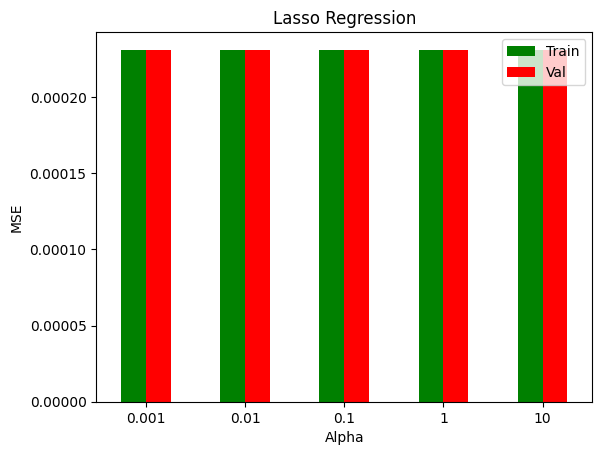

In [143]:
train_color,val_color = 'green','red'
lasso_df = pd.DataFrame(lasso_alpha_dict).T
lasso_df.columns = ['Train','Val']
lasso_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Lasso Regression',xlabel='Alpha',ylabel='MSE')

In [144]:
#Coefficients

val_list = [[key]+lasso_model[key].coef_.tolist() for key in lasso_alpha_dict.keys()]
lasso_coeff_df = pd.DataFrame(val_list,columns=['Alpha Value']+X_train.columns.tolist())
lasso_coeff_df

,Alpha Value,Mkt-RF,SMB,HML,RMW,CMA
0,0.001,0.0,-0.0,0.0,-0.0,-0.0
1,0.01,0.0,-0.0,0.0,-0.0,-0.0
2,0.1,0.0,-0.0,0.0,-0.0,-0.0
3,1,0.0,-0.0,0.0,-0.0,-0.0
4,10,0.0,-0.0,0.0,-0.0,-0.0


## RIDGE REGRESSION

<AxesSubplot:title={'center':'Ridge Regression'}, xlabel='Alpha', ylabel='MSE'>

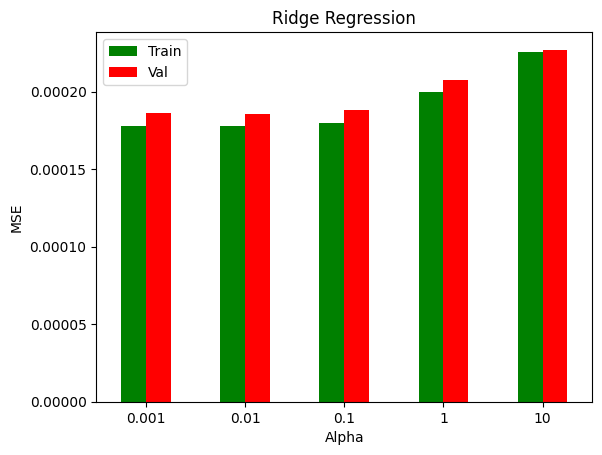

In [126]:
train_color,val_color = 'green','red'
ridge_df = pd.DataFrame(ridge_alpha_dict).T
ridge_df.columns = ['Train','Val']
ridge_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Ridge Regression',xlabel='Alpha',ylabel='MSE')

In [127]:
val_list = [[key]+ridge_model[key].coef_.tolist()[0] for key in ridge_alpha_dict.keys()]
ridge_coeff_df = pd.DataFrame(val_list,columns=['Alpha Value']+X_train.columns.tolist())
ridge_coeff_df

,Alpha Value,Mkt-RF,SMB,HML,RMW,CMA
0,0.001,0.554646,-0.094405,0.366510,-0.240282,-0.054735
1,0.01,0.551218,-0.086515,0.348550,-0.226692,-0.045673
2,0.1,0.505743,-0.046191,0.240587,-0.155471,-0.019888
3,1,0.255817,-0.007699,0.058493,-0.056359,-0.017174
4,10,0.042938,-0.000854,0.006400,-0.008845,-0.003795


## ELASTIC REGRESSION

In [128]:
from sklearn.model_selection import GridSearchCV
import numpy as np
params_grid = {
    "alpha": alpha_list,
    "l1_ratio": np.arange(0.0, 1.0, 0.1)
}

elastic_net = ElasticNet()
elasticnet_grid = GridSearchCV(elastic_net,param_grid=params_grid,n_jobs=-1,cv=4,return_train_score=True,scoring='neg_mean_squared_error')

elasticnet_grid.fit(X_train,y_train)

c:\Users\astar\anaconda3\envs\PyTorch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.580e-01, tolerance: 1.351e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=4, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [129]:
elastic_reg = ElasticNet(alpha=0.1,l1_ratio=0.1,random_state=42)
res = cross_validate(elastic_reg,X_train,y_train,scoring='neg_mean_squared_error',cv=4,return_train_score=True)

In [130]:
# elasticnet_grid.cv_results_
import optuna
from sklearn.exceptions import ConvergenceWarning
from optuna.visualization import plot_parallel_coordinate

alpha_list=[0.001, 0.01, 0.1, 1, 10]
l1_ratio_list = np.arange(0.0,1.0,0.1).tolist()

search_space= {
        "alpha":alpha_list,
        "l1_ratio":l1_ratio_list
    }


def objective(trial:optuna.Trial):
    alpha = trial.suggest_categorical("alpha",alpha_list)
    l1_ratio = trial.suggest_categorical("l1_ratio",l1_ratio_list)
    elastic_reg = ElasticNet(alpha=alpha,l1_ratio=l1_ratio,random_state=42)
    res = cross_validate(elastic_reg,X_train,y_train,scoring='neg_mean_squared_error',cv=4,return_train_score=True)
    
    return -res['test_score'].mean()
grid_sampler = optuna.samplers.GridSampler(search_space=search_space)
study = optuna.create_study(sampler=grid_sampler,study_name="Elastic net")
study.optimize(objective,catch=(ConvergenceWarning,))

plot_parallel_coordinate(study)

[I 2023-02-12 20:23:24,483] A new study created in memory with name: Elastic net
[I 2023-02-12 20:23:24,552] Trial 0 finished with value: 0.00023114109426687672 and parameters: {'alpha': 0.01, 'l1_ratio': 0.1}. Best is trial 0 with value: 0.00023114109426687672.
[I 2023-02-12 20:23:24,613] Trial 1 finished with value: 0.00023114109426687672 and parameters: {'alpha': 1, 'l1_ratio': 0.30000000000000004}. Best is trial 0 with value: 0.00023114109426687672.
[I 2023-02-12 20:23:24,684] Trial 2 finished with value: 0.00023114109426687672 and parameters: {'alpha': 0.01, 'l1_ratio': 0.9}. Best is trial 0 with value: 0.00023114109426687672.
[I 2023-02-12 20:23:24,748] Trial 3 finished with value: 0.00023114109426687672 and parameters: {'alpha': 0.001, 'l1_ratio': 0.2}. Best is trial 0 with value: 0.00023114109426687672.
[I 2023-02-12 20:23:24,811] Trial 4 finished with value: 0.00023114109426687672 and parameters: {'alpha': 0.1, 'l1_ratio': 0.5}. Best is trial 0 with value: 0.000231141094266876

In [131]:
study.best_params

{'alpha': 0.001, 'l1_ratio': 0.0}

In [132]:
val_list = [elasticnet_grid.best_estimator_.coef_.tolist()+[elasticnet_grid.best_estimator_.intercept_[0]]]
elastic_coeff_df = pd.DataFrame(val_list,columns=X_train.columns.tolist()+['Intercept'])
elastic_coeff_df

,Mkt-RF,SMB,HML,RMW,CMA,Intercept
0,0.069717,-0.001444,0.010916,-0.014442,-0.006011,0.000459


## STOCHASTIC GRADIENT DESCENT

In [133]:
import numpy as np
m = len(X_train)
np.random.seed(42)

import math
from tqdm import tqdm

def get_batches(X:pd.DataFrame,y:pd.DataFrame,batch_size:int):
    num_train = X.shape[0]

    indices = np.arange(num_train)
    np.random.shuffle(indices)

    for start_idx in range(0,num_train,batch_size):
        #Ensures that we pick the required number of elements till the last element
        end_idx = min(start_idx+batch_size,num_train)
        batch_idx = indices[start_idx:end_idx]

        yield X.values[batch_idx],y.values[batch_idx]

def get_loss(X,y,weights_list:list):
    losses = []
    val_len = X.shape[0]
    for weight in weights_list:
        curr_weight_loss = 0.0
        for validation_data in zip(X.values,y.values):
            X_curr,y_curr = validation_data
            y_pred = X_curr@weight
            curr_weight_loss+=(y_pred[0]-y_curr)**2
        losses.append(curr_weight_loss/val_len)
    return losses

def learning_rate_scheduler(curr_iter:int,initial_lr:float):
    return initial_lr/math.exp(curr_iter)
    
def minibatch_sgd(X,y,batch_size:int=32,lr0:float=0.1,num_epochs:int=100):
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X,y,test_size=0.1,random_state=42,shuffle=True)
    weight_path_sgd = []
    weight = np.random.randn(X_train.shape[1],1) 
    train_loss = []
    # scale = X_train_.shape[0]//batch_size
    for epoch in tqdm(range(num_epochs)):
        batch_iterator = get_batches(X_train_,y_train_,batch_size)
        curr_train_loss = 0.0
        for idx,batches in enumerate(batch_iterator):
            X_curr,y_curr = batches
            # y_curr = np.expand_dims(y_curr,axis=1)
            grads = 2/batch_size * X_curr.T.dot(X_curr.dot(weight) - y_curr)
            # eta = learning_rate_scheduler(idx/scale,lr0)
            weight = weight - lr0*grads
        train_loss.append(get_loss(X_train_,y_train_,[weight])[0])
        weight_path_sgd.append(weight)
    val_loss = get_loss(X_val_,y_val_,weight_path_sgd)

    return weight_path_sgd,train_loss,val_loss

In [155]:
%%time
weight_path_sgd,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.0001,num_epochs=200,batch_size=16)

100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


CPU times: total: 27.9 s
Wall time: 45.9 s


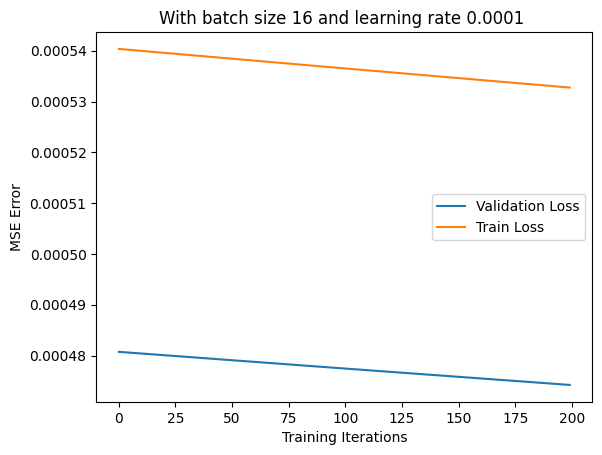

In [156]:
import matplotlib.pyplot as plt
plt.plot(val_loss,label='Validation Loss')
plt.plot(train_loss,label='Train Loss')
# plt.plot(test_loss,label='Test Loss')
plt.xlabel('Training Iterations')
plt.ylabel('MSE Error')
plt.title(f'With batch size {16} and learning rate {0.0001} ')
# plt.ylim(min(min(val_loss),min(train_loss)),max(max(val_loss),max(train_loss)))
plt.legend()

In [157]:
%%time
weight_path_sgd,train_loss,val_loss = minibatch_sgd(X_train,y_train,lr0=0.0001,num_epochs=100,batch_size=1)

100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


CPU times: total: 14.1 s
Wall time: 21.4 s


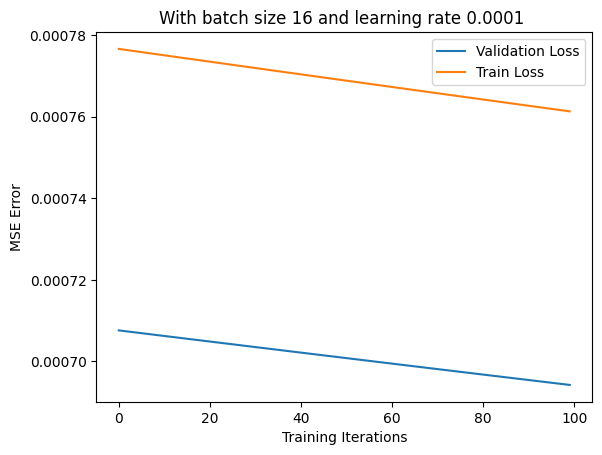

In [158]:
import matplotlib.pyplot as plt
plt.plot(val_loss,label='Validation Loss')
plt.plot(train_loss,label='Train Loss')
# plt.plot(test_loss,label='Test Loss')
plt.xlabel('Training Iterations')
plt.ylabel('MSE Error')
plt.title(f'With batch size {16} and learning rate {0.0001} ')
# plt.ylim(min(min(val_loss),min(train_loss)),max(max(val_loss),max(train_loss)))
plt.legend()

## POLYNOMIAL REGRESSION

In [159]:
from sklearn.preprocessing import PolynomialFeatures

degree_list = [2,3,5]


from sklearn.metrics import mean_squared_error

lin_reg_poly = {}
lin_reg_poly_model = {}
X_sub_train = X_train[X_train.columns[1:8]]
for deg in degree_list:
    poly_transform = PolynomialFeatures(degree=deg,interaction_only=False)
    cv_poly_reg = LinearRegression()
    X_poly = poly_transform.fit_transform(X_train)
    cv_lin_reg_poly = cross_validate(cv_poly_reg,X_poly,y_train,cv=4,scoring='neg_mean_squared_error',return_train_score=True,n_jobs=-1)

    lin_reg_poly.update({f'{deg}':[-cv_lin_reg_poly['train_score'].mean(),-cv_lin_reg_poly['test_score'].mean()]})
    lin_reg_poly_model.update({f'{deg}':cv_poly_reg.fit(X_poly,y_train)})


In [160]:
train_color,val_color = 'green','red'
poly_df = pd.DataFrame(lin_reg_poly).T
poly_df.columns = ['Train','Val']
print(poly_df)

      Train       Val
2  0.000175  0.000198
3  0.000161  0.000455
4  0.000151  0.010323


<AxesSubplot:title={'center':'Polynomial Regression'}, xlabel='Degree', ylabel='MSE'>

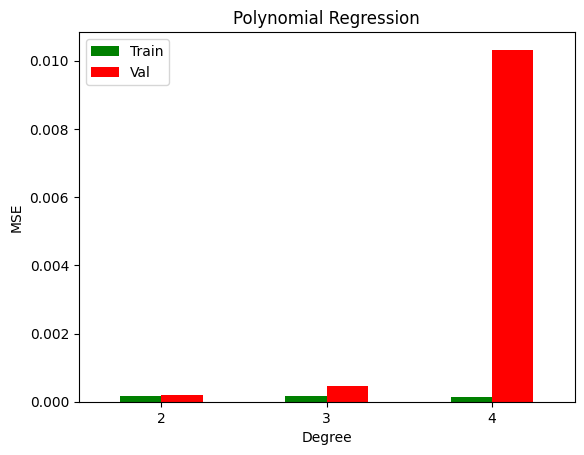

In [161]:
poly_df.plot.bar(rot=0, color={"Train": train_color, "Val": val_color},title='Polynomial Regression',xlabel='Degree',ylabel='MSE')